# Análise de Risco de Crédito - Divisão e Balanceamento

In [1]:
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential

from numpy import concatenate, vstack, argmin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using Theano backend.


In [2]:
# Construir DataFrame a partir da base de dados.
data_set = pd.read_csv('data/TRN', sep='\t', index_col=0)

In [3]:
# Exibe as 5 primeiras linhas da base de dados.
data_set.head(5)

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
INDEX,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0


In [4]:
# Separa as classes em DataFrames distintos.
class_1_df = data_set.loc[data_set['IND_BOM_1_2'] == 0] # Bom pagador.
class_2_df = data_set.loc[data_set['IND_BOM_1_2'] == 1] # Mau pagador.

In [5]:
# Separa "features" dos "targets" para cada classe, transformando-os em numpy arrays.
class_1_X = class_1_df.iloc[:, :-2].values
class_1_y = class_1_df.iloc[:, -1].values

class_2_X = class_2_df.iloc[:, :-2].values
class_2_y = class_2_df.iloc[:, -1].values

In [6]:
# Treino: 50%, Validação: 25%, Teste: 25% (para ambas as classes).
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(
    class_1_X, class_1_y, test_size=0.25, random_state=42, stratify=class_1_y)

class_1_X_train, class_1_X_val, class_1_y_train, class_1_y_val = train_test_split(
    class_1_X_train, class_1_y_train, test_size=(1./3), random_state=42, stratify=class_1_y_train)

class_2_X_train, class_2_X_test, class_2_y_train, class_2_y_test = train_test_split(
    class_2_X, class_2_y, test_size=0.25, random_state=42, stratify=class_2_y)

class_2_X_train, class_2_X_val, class_2_y_train, class_2_y_val = train_test_split(
    class_2_X_train, class_2_y_train, test_size=(1./3), random_state=42, stratify=class_2_y_train)

In [7]:
# Concatena os arrays de treinamento das classes (features e targets).
X_train = vstack((class_1_X_train, class_2_X_train))
y_train = concatenate([class_1_y_train, class_2_y_train])

# Concatena os arrays de validação das classes (features e targets).
X_val = vstack((class_1_X_val, class_2_X_val))
y_val = concatenate([class_1_y_val, class_2_y_val])

# Concatena os arrays de teste das classes (features e targets).
X_test = vstack((class_1_X_test, class_2_X_test))
y_test = concatenate([class_1_y_test, class_2_y_test])

In [8]:
# Over-sampling os conjuntos de treinamento e validação da classe 2 (minoritária).
ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

In [9]:
# Aleatorização.
X_train, y_train = shuffle(X_train_resampled, y_train_resampled, random_state=42)
X_val, y_val = shuffle(X_val_resampled, y_val_resampled, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [10]:
# Número de features do nosso data set.
input_dim = X_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida e função de ativação.
# Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set).
classifier.add(Dense(64, activation='tanh', input_dim=input_dim))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='sigmoid'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
sgd = optimizers.SGD(lr=0.05)
classifier.compile(optimizer=sgd, loss='mean_squared_error')

In [11]:
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_val, y_val))

Train on 255096 samples, validate on 127550 samples
Epoch 1/200
255096/255096 [==============================] - 5s 20us/step - loss: 0.2322 - val_loss: 0.2290
Epoch 2/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2269 - val_loss: 0.2291
Epoch 3/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2259 - val_loss: 0.2267
Epoch 4/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2252 - val_loss: 0.2250
Epoch 5/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2245 - val_loss: 0.2252
Epoch 6/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2238 - val_loss: 0.2243
Epoch 7/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2232 - val_loss: 0.2249
Epoch 8/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.2226 - val_loss: 0.2235
Epoch 9/200
255096/255096 [==============================] - 4s 16us/step - loss: 0.

255096/255096 [==============================] - 4s 17us/step - loss: 0.2085 - val_loss: 0.2269
Epoch 76/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2082 - val_loss: 0.2278
Epoch 77/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2081 - val_loss: 0.2294
Epoch 78/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2080 - val_loss: 0.2341
Epoch 79/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2078 - val_loss: 0.2291
Epoch 80/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2077 - val_loss: 0.2294
Epoch 81/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2076 - val_loss: 0.2287
Epoch 82/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2073 - val_loss: 0.2283
Epoch 83/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.2073 - val_loss: 0.2287
Epoch 84/200
255096/255096 [====

Epoch 150/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1992 - val_loss: 0.2365
Epoch 151/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1991 - val_loss: 0.2380
Epoch 152/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1990 - val_loss: 0.2378
Epoch 153/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1990 - val_loss: 0.2364
Epoch 154/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1988 - val_loss: 0.2384
Epoch 155/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1988 - val_loss: 0.2370
Epoch 156/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1987 - val_loss: 0.2395
Epoch 157/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1985 - val_loss: 0.2370
Epoch 158/200
255096/255096 [==============================] - 4s 17us/step - loss: 0.1984 - val_loss: 0.2371
Epoch 159/

In [12]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

<IPython.core.display.Javascript object>


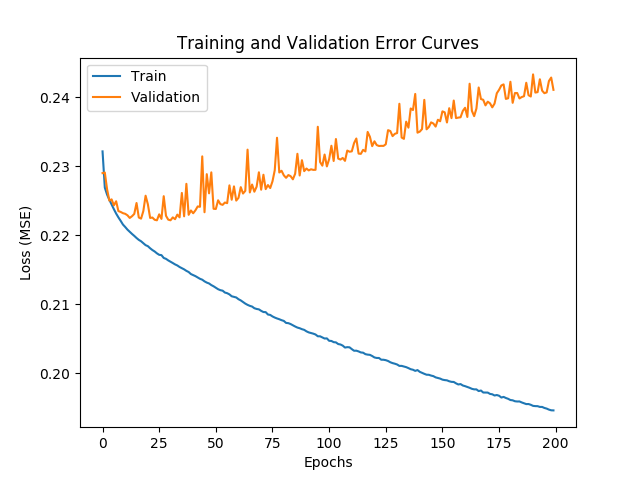

In [13]:
plot_training_error_curves(history)

In [14]:
## Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Matriz de confusão no conjunto de teste:
[[36799 26976]
 [11714 21811]]
()
Train Loss:       0.2174
Validation Loss:  0.2222

Performance no conjunto de teste:
()
Accuracy:         0.6024
Recall:           0.6506
Precision:        0.4471
F1:               0.5300
AUROC:            0.6561
AUPR:             0.4784
